In [1]:
# A notebook for making some graphics/tables for the paper
import cv2
import progressbar
import pickle
import numpy as np
from utils.Constants import *
import matplotlib.pyplot as plt
from ForecastModels.Models import *

with open("./data/dataset_stats.pkl", "rb") as f:
    stats = pickle.load(f)

def get_outputs(s):
    """
    Helps to load in different outputs files for model performance tables
    """
    with open("./data/%s.pkl" % s, 'rb') as f:
        outputs = pickle.load(f)
        return list(sorted(outputs, key=lambda x: x[2][1][-1]))

In [2]:
def do_hist(ax, hist, row, col):
    v, bins = hist
    for i in range(len(bins) - 1):
        bins[i] = (bins[i] + bins[i + 1]) / 2
    bins = bins[:-1]

    ax.bar(bins, v)
        
def pv_in_out_hist(s, data_type='raw'):
    """
    Draws the large 4x2 table of histograms for position and velocity data, for the given data_type
    """
    num_rows = 4
    fig, axs = plt.subplots(num_rows, 2, figsize=(10, 15))
    fig.suptitle('Position and Velocity Histogram for %s Data' % data_type.upper(), fontsize=20, y=0.9)
    
    for i, suprow in enumerate(['p', 'v']):
        for j, row in enumerate(['in', 'out']):
            for k, axis in enumerate(['x', 'y']):
                ax = axs[i*2 + j, k]
                do_hist(ax, s['all']['_'.join([suprow, row, data_type])]['hist_' + axis], i*2 + j, k)
                
                if i + j * 2 == num_rows - 1:
                    ax.set_xlabel(axis.upper() + " Values", fontsize=16)
                if k == 0:
                    ax.set_ylabel(suprow + "_" + row, fontsize=16)
    
    plt.savefig('./data/plots/pv_in_out_hist_%s.jpg' % data_type, bbox_inches='tight')
    plt.show()

def speed_hist(s, data_type='raw'):
    """
    Draws the single histogram for the speed data of the given data_type
    """
    fig = plt.figure(figsize=(8, 8))
    fig.suptitle('Speed Histogram for %s Data' % data_type.upper(), fontsize=20, y=0.95)
    
    v, bins = s['all']['speed' if data_type == 'raw' else 'speed_step']['hist_x']
    
    for i in range(len(bins) - 1):
        bins[i] = (bins[i] + bins[i + 1]) / 2
    bins = bins[:-1]

    plt.bar(bins, v)
    plt.savefig("./data/plots/speed_hist.jpg", bbox_inches='tight')
    plt.show()

In [ ]:
# Make the histogram graphics
pv_in_out_hist(stats, data_type='step')
pv_in_out_hist(stats, data_type='raw')
speed_hist(stats)

In [3]:
# Functions for the city map
_MAP_X_SIZE = 5000
_MAP_Y_SIZE = 4500
_MAP_NORM_MULT = 1

def draw_map(points, norms):
    image = np.ones([_MAP_Y_SIZE, _MAP_X_SIZE, 3])

    for i in progressbar.progressbar(range(len(points))):
        p, n = points[i], norms[i]
        p2 = (p + _MAP_NORM_MULT * n)
        cv2.line(image, tuple(p.astype(int)), tuple(p2.astype(int)), (0, 0, 255), thickness=1)

    cv2.imshow("Image", image)
    cv2.imwrite("./data/plots/city_map.jpg", image)
    cv2.waitKey(0)
    cv2.destroyAllWindows()

def make_city_map(max_files=None):
    """
    Loads in all the data for the city map, then draws the map using cv2
    """
    lane, lane_norm = None, None
    files = os.listdir(TRAINING_PATH)
    files = files[:max_files] if max_files is not None else files
    print("Loading files...")
    for i in progressbar.progressbar(range(len(files))):
        with open(os.path.join(TRAINING_PATH, files[i]), 'rb') as f:
            data = pickle.load(f)
        if lane is None:
            lane = data['lane'][:, :2]
            lane_norm = data['lane_norm'][:, :2]
        else:
            lane = np.append(lane, data['lane'][:, :2], axis=0)
            lane_norm = np.append(lane_norm, data['lane_norm'][:, :2], axis=0)
    
    print("Drawing map...")
    draw_map(lane, lane_norm)

In [ ]:
# Make the city map (Note: this takes a long time if you don't set max_files to a smaller value)
make_city_map()

In [6]:
# Functions to help with table building
# Let's just say my Italian heritage would be quite proud of this spaghetti code I've written...

# The actual RMSE on Kaggle
val_rmse = {
    'SGDRegressorModel': 2.53939,
    'KernelRidgeModel': 2.55977,
    'MLPModel': 2.95552,
    'PassiveAggressiveModel': 3.02030,
    'ElasticNetModel': 2.84930,
    'RandomForestModel': 2.46393,
    'GeneralLinearModel': 2.67680,
    'AdaBoostModel': 2.37659,
    'RNNModel': 2.74779,
}

def _extra(m, kwargs, table_type):
    """
    Extra models to add in on top of the best in each model
    """
    if table_type == 'initial':
        if m.startswith("Random"):
            if kwargs['data_type'] == 'step' and kwargs['norm_func'] == 'std_step':
                return True
        elif m.startswith("Elastic"):
            return kwargs['data_type'] == 'raw' and kwargs['norm_func'] == 'noop'
        elif m.startswith("MLP"):
            return kwargs['data_type'] == 'raw'
    elif table_type == 'secondary':
        if m.startswith("MLP"):
            if kwargs['dp'] is not None and kwargs['dp'] >= 0.6 and kwargs['kernel_regularizer'] is None and kwargs['hidden_layers'] == 5:
                return True
            if (kwargs['dp'] is None or kwargs['dp'] == 0) and kwargs['kernel_regularizer'] in ['l1', 'l2', 'l1_l2'] and kwargs['hidden_layers'] == 5:
                return True
            if kwargs['dp'] is not None and kwargs['dp'] == 0.2 and kwargs['kernel_regularizer'] == 'l2' and kwargs['hidden_layers'] == 5:
                return True
        if m.startswith("Random"):
            return kwargs['n_estimators'] == 100 and kwargs['max_depth'] == None and 'include_lanes' in kwargs
    elif table_type == 'final':
        if m.startswith("RNN"):
            return kwargs['rnn_type'] == 'rnn'
    return False


def get_top_n_outputs(s, table_type, top_n=2):
    outputs = get_outputs(s)
    d = {}
    for m, kwargs, (rmse, real_rmse) in outputs:
        idx = np.argmin(real_rmse)
        a = [kwargs, [rmse[idx], real_rmse[idx]]]
        if m not in d:
            d[m] = []
        if len(d[m]) < top_n or _extra(m, kwargs, table_type):
            d[m].append(a)
    return d

def _fix_kwargs(m, table_type, kwargs):
    """
    Removes all the unecessary kwargs
    """
    if table_type == 'initial':
        l = ['epochs', 'batch_norm', 'dp', 'kernel_regularizer', 'include_lanes', 'extra_features', 'hidden_layers']
    elif table_type == 'secondary':
        l = ['epochs', 'batch_norm', 'include_lanes', 'extra_features']
        if m.startswith("Random"):# and ('include_lanes' in kwargs and 'extra_features' in kwargs and not (kwargs['include_lanes'] or kwargs['extra_features'])):
            l = l[:2]
    elif table_type == 'final':
        l = ['epochs', 'batch_norm', 'callback', 'batch_size']
    elif table_type == 'best':
        l = ['epochs', 'batch_norm', 'callback', 'batch_size']
    else:
        raise ValueError("Unknown table_type: %s" % table_type)
    
    l += ['vmin', 'vmax', 'std_min', 'std_max']
    for _l in l:
        if _l in kwargs:
            del kwargs[_l]
    return kwargs

def _table_line(model_name, rmses, table_type, data_type='step', max_data=10_000, norm_func='noop', **kwargs):
    if model_name == 'MLPModel' or max_data is None:
        max_data = 'all'
    elif model_name == 'RNNModel':
        max_data = 'all' if max_data == 10_000 else max_data
    kwargs = _fix_kwargs(model_name, table_type, kwargs)
    extra_kwargs = " \\newline ".join([("'%s': '%s'" if isinstance(v, str) else "'%s': %s") % (k, v) for k, v in kwargs.items()]) if len(kwargs.keys()) > 0 else "N/A"
    if table_type in ['secondary', 'final']:
        extra_kwargs = extra_kwargs.replace(" ", "")
        ek = extra_kwargs.split("\\newline")
        temp = ""
        for i in range(len(ek)):
            if i % 2 == 1:
                continue
            if i == len(ek) - 1:
                temp += ek[i]
            elif i == len(ek) - 2:
                temp += ek[i] + ", " + ek[i + 1]
            else:
                temp += ek[i] + ", " + ek[i + 1] + " \\newline "
        extra_kwargs = temp.replace(":", ": ")
    real_rmse = ("%0.4f" if rmses[1] < 1000 else "%.2E") % rmses[1]
    s = " & ".join((model_name, data_type, str(max_data), norm_func, extra_kwargs, real_rmse))
    if table_type == 'best':
        s = " & ".join((s, "%0.4f" % val_rmse[model_name]))
    print(s.replace("_", "\\_"), "\\\\\hline")

def _build_initial_table():
    outputs = get_top_n_outputs("initial_sklearn_test_models_3", 'initial')
    outputs.update(get_top_n_outputs("initial_nn_test_models_1", 'initial'))
    
    for k in outputs:
        for m in outputs[k]:
            w, v = m[0], m[1]
            _table_line(k, v, 'initial', **w)

def _build_secondary_table():
    outputs = get_top_n_outputs("secondary_sklearn_test_models_1", 'secondary', top_n=2)
    outputs.update(get_top_n_outputs("secondary_nn_test_models_1", 'secondary', top_n=2))
    
    for k in outputs:
        for m in outputs[k]:
            w, v = m[0], m[1]
            _table_line(k, v, 'secondary', **w)

def _build_final_table():
    outputs = get_top_n_outputs("final_nn_test_models_5", 'final', top_n=10)
    
    for k in outputs:
        for m in outputs[k]:
            w, v = m[0], m[1]
            _table_line(k, v, 'final', **w)

def _build_best_table():
    outputs = get_top_n_outputs("best_sklearn_test_models_2", 'secondary', top_n=10)
    outputs.update(get_top_n_outputs("best_nn_test_models_1", 'secondary', top_n=10))
    
    for k in outputs:
        for m in outputs[k]:
            w, v = m[0], m[1]
            _table_line(k, v, 'best', **w)

def build_table(table):
    col_names = ['Model Name', 'Data Type', 'Datapoints', 'Norm Func', 'Extra Kwargs', 'Real RMSE']
    col_names += ['Val RMSE'] if table == 'best' else []
    print(" & ".join(col_names), "\\\\\hline\hline")
    
    if table == 'initial':
        _build_initial_table()
    elif table == 'secondary':
        _build_secondary_table()
    elif table == 'final':
        _build_final_table()
    elif table == 'best':
        _build_best_table()
    

In [7]:
# Make the latex output for the tables for each set of tests
build_table("initial")
print("\n\n")
build_table('secondary')
print("\n\n")
build_table('final')
print("\n\n")
build_table('best')

Model Name & Data Type & Datapoints & Norm Func & Extra Kwargs & Real RMSE \\\hline\hline
RandomForestModel & step & 10000 & standardize & 'n\_estimators': 100 \newline 'max\_depth': None & 3.0305 \\\hline
RandomForestModel & step & 10000 & noop & 'n\_estimators': 100 \newline 'max\_depth': None & 3.0384 \\\hline
RandomForestModel & step & 10000 & std\_step & 'n\_estimators': 100 \newline 'max\_depth': None & 4.1049 \\\hline
SGDRegressorModel & step & 10000 & standardize & 'loss': 'huber' \newline 'penalty': 'l1' & 3.0977 \\\hline
SGDRegressorModel & step & 10000 & noop & 'loss': 'huber' \newline 'penalty': 'l1' & 3.2257 \\\hline
GeneralLinearModel & step & 10000 & standardize & 'power': 0 & 3.2115 \\\hline
GeneralLinearModel & step & 10000 & noop & 'power': 0 & 3.8811 \\\hline
KernelRidgeModel & step & 10000 & linear & N/A & 3.2712 \\\hline
KernelRidgeModel & step & 10000 & noop & N/A & 3.9879 \\\hline
ElasticNetModel & step & 10000 & standardize & N/A & 3.3287 \\\hline
ElasticNetMode

In [31]:
# Functions to help build Table 1, the stats table

def _stats_table_line(k, d, dataset):
    if 'speed' in k:
        _f = lambda a: "%0.3f, N/A" % (a[0])
    else:
        _f = lambda a: "%0.3f, %0.3f" % (a[0], a[1])
    vals = [dataset, k.replace('_', '\\_')] + [_f(d[s]) for s in ['min', 'max', 'abs_min', 'mean', 'std']]
    print(' & '.join(vals) + "\\\\\hline")

def stats_table(stats):
    col_names = ['Dataset', 'Section', 'min', 'max', 'abs\_min', 'mean', 'std']
    print(" & ".join(col_names) + "\\\\\hline")
    for key in stats['all']:
        if isinstance(stats['all'][key], dict):
            _stats_table_line(key, stats['all'][key], 'all')
    val_keys = ['p_raw', 'v_raw', 'p_step', 'v_step', 'lane_raw', 'lane_step']
    for key in stats['val']:
        if isinstance(stats['val'][key], dict) and key in val_keys:
            _stats_table_line(key, stats['val'][key], 'val')

In [53]:
stats_table(stats)

Dataset & Section & min & max & abs\_min & mean & std\\\hline
all & p\_raw & -60.595, 208.973 & 4772.961, 4097.958 & 0.001, 208.973 & 1473.029, 2169.150 & 1281.130, 870.558\\\hline
all & v\_raw & -222.632, -187.712 & 290.527, 270.284 & 0.000, 0.000 & 0.149, -0.180 & 4.631, 5.712\\\hline
all & p\_step & -22.263, -18.771 & 29.053, 27.028 & 0.000, 0.000 & 0.015, -0.018 & 0.463, 0.571\\\hline
all & v\_step & -361.844, -332.544 & 350.051, 336.191 & 0.000, 0.000 & -0.001, 0.000 & 3.582, 3.985\\\hline
all & p\_off & -260.550, -226.134 & 213.915, 242.976 & 0.000, 0.000 & -2.137, -1.619 & 33.269, 36.901\\\hline
all & v\_off & -124.087, -107.675 & 169.078, 122.464 & 0.000, 0.000 & 0.360, 0.522 & 6.525, 7.779\\\hline
all & lane\_raw & -75.963, 189.202 & 4791.579, 4121.429 & 0.000, 189.202 & 960.756, 916.905 & 1236.886, 1339.733\\\hline
all & lane\_step & -291.912, -318.578 & 293.198, 287.188 & 0.000, 0.000 & 0.151, 1.015 & 36.634, 44.051\\\hline
all & lane\_norm & -18.564, -16.691 & 18.801, 16.70

In [8]:
# Functions for doing model performance analysis
_COLORS = ['b', 'r', 'g']

def nn_rmse_graph(subplots=False):
    """
    Plots the RMSE of the best neural network models
    :param subplots: if True, will split into multiple subplots. Otherwise will combine all plots onto same graph.
    """
    outputs = get_outputs('best_nn_test_models_1')
    n_models = len(outputs)
    
    if subplots:
        fig, axs = plt.subplots(1, n_models, figsize=(6 * n_models, 6))
    else:
        fig = plt.figure(figsize=(6, 6))
    fig.suptitle('NN RMSE per Epoch', fontsize=20)
    
    for i in range(n_models):
        y = outputs[i][2][1]
        x = list(range(len(y)))
        
        if subplots:
            ax = axs if n_models == 1 else axs[i]
            ax.plot(x, y, label=outputs[i][0], color=_COLORS[i])
            ax.set(xlabel='Epoch', ylabel='RMSE', ylim=(0, 5), title=outputs[i][0])
        else:
            plt.plot(x, y, label=outputs[i][0], color=_COLORS[i])
            plt.xlabel('Epoch')
            plt.ylabel('RMSE')
            plt.ylim((0, 5))
            plt.legend()
    
    plt.savefig("./data/plots/nn_rmse.jpg")
    plt.show()

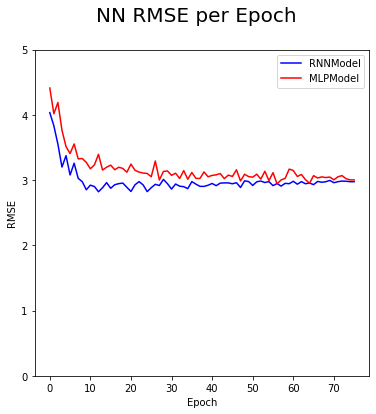

In [9]:
nn_rmse_graph(subplots=False)

In [16]:
# For plotting the car movements

def plot_car(model, min_axis_size=10):
    x, y_pred, y_true = model.test_predictions()
    
    # The final displacement errors
    fdes = np.sum((y_pred[:, -2:] - y_true[:, -2:])**2, axis=1) ** 0.5
    
    # The average displacement errors
    ades = None
    for i in range(30):
        s, e = i * 2, i * 2 + 1
        ade = np.sum((y_pred[:, s:e] - y_true[:, s:e])**2, axis=1) ** 0.5
        if ades is None:
            ades = ade
        else:
            ades += ade
    ades /= 30  # Because 30 prediction time steps
    
    # The biggest RMSE
    rmses = np.sum((y_pred - y_true)**2, axis=1) ** 0.5 / 30
    
    fig, axs = plt.subplots(3, 4, figsize=(18, 18))
    fig.suptitle("Predicated Paths of %s" % model.__class__.__name__, fontsize=16, y=0.93)
    
    for i, (arr, name) in enumerate(zip([fdes, ades, rmses], ['FDE', 'ADE', 'RMSE'])):
        idxs = np.argsort(arr)
        mean_idx = np.argmin(abs(arr - np.mean(arr)))
        median_idx = np.argmin(abs(arr - np.median(arr)))
        for j, (idx, stat) in enumerate(zip([idxs[0], median_idx, mean_idx, idxs[-1]], ['Min', 'Median', 'Mean', 'Max'])):
            ax = axs[i, j]
            
            start = x[idx][:60].reshape([-1, 2])
            ax.plot(start[:, 0], start[:, 1], color='orange', label='p_in' if i + j == 0 else None)
            
            pred = np.append(start[-1:], y_pred[idx].reshape([-1, 2]), axis=0)
            ax.plot(pred[:, 0], pred[:, 1], color='red', label='y_pred' if i + j == 0 else None)
            
            true = np.append(start[-1:], y_true[idx].reshape([-1, 2]), axis=0)
            ax.plot(true[:, 0], true[:, 1], color='blue', label='y_true' if i + j == 0 else None)
            
            # Set xlim and ylim nicely
            l, r = ax.get_xlim()
            if r - l < min_axis_size:
                d = (min_axis_size - (r - l)) / 2
                ax.set(xlim=(l - d, r + d))
            
            l, r = ax.get_ylim()
            if r - l < min_axis_size:
                d = (min_axis_size - (r - l)) / 2
                ax.set(ylim=(l - d, r + d))
            
            if i == 0:
                ax.set(title=stat + "\n" + name + " = %0.2f" % arr[idx])
            else:
                ax.set(title=name + " = %0.2f" % arr[idx])
            if j == 0:
                ax.set_ylabel(name, fontsize=12)
            
    fig.legend(bbox_to_anchor = [0.75, 0.93])
    
    plt.savefig("./data/plots/%s_car_paths.jpg" % model.__class__.__name__)

In [13]:
model = AdaBoostModel(**{'max_depth': None, 'max_data': 50_000, 'data_type': 'step', 'norm_func': 'standardize', 'load_model': True})

Loading dataset...
Loading dataset statistics...
Statistics loaded!
Normalizing data...


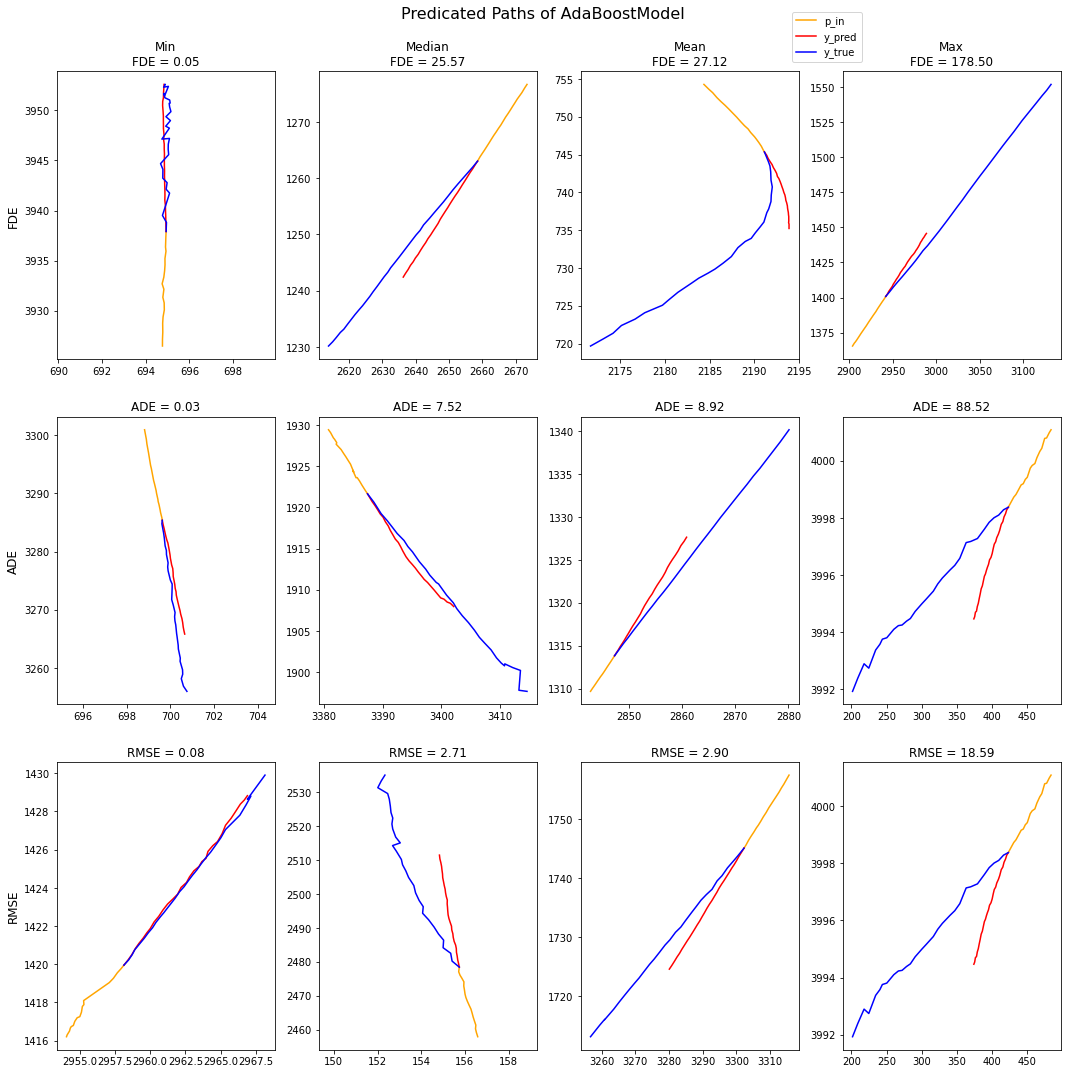

In [17]:
plot_car(model)

In [15]:
model.other_metrics()

(0.6848852621054828,
 2.7543497018279703,
 2.4278326737721237e-05,
 15.413027970658643,
 7.961628715994694)